# Original CvT-Model

<img src="./../CvT-Original.drawio.png?raw=1" alt="CvT-Modell mit Convolutional Embedding" title="CvT-Modell mit Convolutional Embedding" height="400" />

Dimensions sind ohne Batch-Size.

## Input-Dimensions

**Dimensions:** $H_0 = 64px, \quad W_0 = 64px, \quad C_0 = 3$ \
**Output-Shape:** `(3, 64, 64)`

## Conv2d

Berechnung Output-Dimensions:

$ \text{kernel size}\ k = 7, \quad \text{stride}\ s = 4, \quad \text{padding}\ p = 3 $ \
$ H_i = \frac{H_{i-1} + 2p - k}{s}\ + 1, \quad W_i = \frac{W_{i-1} + 2p - k}{s}\ + 1 $

**Output-Dimensions:** $H_1 = 16px, \quad W_1 = 16px, \quad C_1 = 64$ \
**Output-Shape:** `(64, 16, 16)`

## Flatten

**Output-Dimensions:** $H_1 W_1 \times C_1 = 16*16 \times 64$ \
**Output-Shape:** `(256, 64)`

## Conv Projection



## Multi-Head Attention

Berechnung der Query-, Key- und Value-Matrizen:

$X \in \mathbb{R}^{H_1 W_1 \times C_1}$ \
$d_k$ ist die Dimension der Value-, Query- und Key-Vektoren \
$W^Q, W^K, W^V \in \mathbb{R}^{C_1 \times d_k}$ \
$Q = XW^Q, \quad K = XW^K, \quad V = XW^V$

$d_k = 64$ \
$Q, K, V \in \mathbb{R}^{256 \times 64}$

**Output-Dimensions:** $256 \times 64$ \
**Output-Shape:** `(256, 64)`

## MLP

Expansion factor: $e = 4$

1. **Step:** Linear ➔ GELU ➔ Dropout
   
   **Output-Dimensions:** $256 \times 64 \times 4 = 256 \times 256$ \
   **Output-Shape:** `(256, 256)`

2. **Step:** Linear ➔ Dropout

    **Output-Dimensions:** $256 \times 256 \times 64 = 256 \times 64$ \
    **Output-Shape:** `(256, 64)`


# Imports

In [1]:
%pip install pytorch-lightning
%pip install torch torchvision
%pip install lightning
%pip install einops
%pip install dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import torch
from einops import rearrange
import torch.nn as nn

IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

# Modell

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvEmbedding(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.LayerNorm(out_channels)

    def forward(self, x):
        x = self.proj(x)  # [B, C, H, W]
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, HW, C]
        x = self.norm(x)
        return x, H, W

class Attention(nn.Module):
    def __init__(self, dim, num_heads, sr_ratio):
        super().__init__()
        self.num_heads = num_heads
        self.sr_ratio = sr_ratio
        self.q = nn.Linear(dim, dim)
        self.kv = nn.Linear(dim, dim * 2)
        self.attn_drop = nn.Dropout(0.1)
        self.proj = nn.Linear(dim, dim)

        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).transpose(1, 2)

        if self.sr_ratio > 1:
            x_ = x.transpose(1, 2).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).transpose(1, 2)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)

        k, v = kv[0], kv[1]  # [B, heads, N, C']
        attn = (q @ k.transpose(-2, -1)) * (1.0 / (C // self.num_heads) ** 0.5)
        attn = self.attn_drop(F.softmax(attn, dim=-1))
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, sr_ratio):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, sr_ratio)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim),
        )

    def forward(self, x, H, W):
        x = x + self.attn(self.norm1(x), H, W)
        x = x + self.mlp(self.norm2(x))
        return x

class CvTStage(nn.Module):
    def __init__(self, in_channels, embed_dim, depth, num_heads, sr_ratio,
                 kernel_size, stride, padding):
        super().__init__()
        self.embedding = ConvEmbedding(in_channels, embed_dim, kernel_size, stride, padding)
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, sr_ratio) for _ in range(depth)
        ])

    def forward(self, x):
        x, H, W = self.embedding(x)
        for blk in self.blocks:
            x = blk(x, H, W)
        return x, H, W

class CvT64(nn.Module):
    def __init__(self, num_classes=200):
        super().__init__()
        self.num_classes = num_classes

        self.stage1 = CvTStage(3, 64, 1, 1, 8, kernel_size=7, stride=4, padding=3)
        self.stage2 = CvTStage(64, 192, 2, 3, 4, kernel_size=3, stride=2, padding=1)
        self.stage3 = CvTStage(192, 384, 10, 6, 2, kernel_size=3, stride=2, padding=1)

        self.head = nn.Sequential(
            nn.LayerNorm(384),
            nn.Linear(384, num_classes)
        )

    def forward(self, x):
        x, _, _ = self.stage1(x)
        x = x.transpose(1, 2).reshape(x.shape[0], 64, 16, 16)
        x, _, _ = self.stage2(x)
        x = x.transpose(1, 2).reshape(x.shape[0], 192, 8, 8)
        x, _, _ = self.stage3(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.head(x)


## Testing

In [4]:
model = CvT64()

dummy_input = torch.randn(8, 3, 64, 64)
output = model(dummy_input)

assert output.shape == (8, 200), f"Expected output shape (8, 200), but got {output.shape}"
print("Model output shape is as expected:", output.shape)

dummy_input = torch.randn(64, 3, 64, 64)
output = model(dummy_input)

assert output.shape == (64, 200), f"Expected output shape (64, 200), but got {output.shape}"
print("Model output shape is as expected:", output.shape)


Model output shape is as expected: torch.Size([8, 200])
Model output shape is as expected: torch.Size([64, 200])


# Dataset

In [5]:
from models.processData import prepare_data_and_get_loaders

train_loader, val_loader, test_loader = prepare_data_and_get_loaders("/datasets/tiny-imagenet-200/tiny-imagenet-200.zip", "data/tiny-imagenet-200")

Data already extracted.


### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


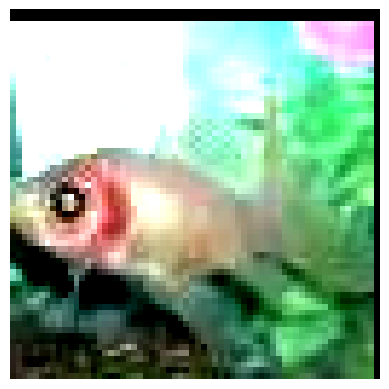

In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

image, label = train_loader.dataset[0]
imshow(image)

# Training

In [ ]:
from models.trainModel import train_test_model

train_test_model(model, train_loader, val_loader, test_loader)

wandb: Currently logged in as: seya-schmassmann-fhnw. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: seya-schmassmann-fhnw (wods). Use `wandb login --relogin` to force relogin


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CvT64              | 26.9 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
26.9 M    Trainable params
0         Non-trainable params
26.9 M    Total params
107.602   Total estimated model params size (MB)
205       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
